# Analysis of Cortical Stim (NIH)

In [14]:
import os
import sys

import pandas as pd
import warnings
import collections
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from pprint import pprint
import copy
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix

sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")

%matplotlib inline
# from edv.base.config.config import FiguresConfig
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from eztrack.edp.loaders.patient.subjectresultsloader import SubjectResultsLoader
from eztrack.edp.loaders.dataset.result.resultloader import ResultLoader
from eztrack.edp.utils.utils import writejsonfile
from eztrack.edp.utils.utils import map_to_win, compute_timepoints

from eztrack.edp.loaders.dataset.clinical.excel_meta import ExcelReader
from eztrack.edp.objects.clinical.master_clinical import MasterClinicalSheet

# import fragility related modules
from eztrack.edv.plot_fragility_heatmap import PlotFragilityHeatmap
from eztrack.edv.baseplot import BasePlotter

# mp.use(FiguresConfig().MATPLOTLIB_BACKEND)
from eztrack.edv.results.plot_distributions import PlotDistributions
from eztrack.edv.base.utils import plot_baseline, plot_boxplot, plot_pr, plot_roc
from eztrack.edp.loaders.centerdata import CenterLoader
from eztrack.base.utils.data_science_utils import cutoff_youdens
from eztrack.edm.classifiers.model.cez_oez_analyzer import FragilitySplitAnalyzer
from eztrack.pipeline.experiments.cez_vs_oez.center_cezvsoez import plot_results


from eztrack.edv.base.utils import plot_baseline, plot_boxplot, plot_pr, plot_roc, plot_confusion_matrix
from eztrack.base.utils.data_science_utils import cutoff_youdens

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def time_warp_seizure(mat, onsetwin, offsetwin, bufferwin):
    # parameters of the resampling length
    ICTAL_LEN = 100
    PREICTAL_LEN = POSTICTAL_LEN = 30
    
    # trim matrix
    mat = mat[...,onsetwin-bufferwin:offsetwin+bufferwin]

    # warp the ictal region
    warped_ictal = PostProcess.resample_mat(mat[..., bufferwin:-bufferwin],
                                            ICTAL_LEN)

    # get the preictal region
    preictal_mat = PostProcess.resample_mat(mat[...,0:bufferwin],
                                            PREICTAL_LEN)

    # get the postictal region
    postictal_mat = PostProcess.resample_mat(mat[...,-bufferwin:],
                                             POSTICTAL_LEN)

    # concatenate preictal, ictal and postictal warped region
    mat = np.concatenate((preictal_mat, warped_ictal, postictal_mat), axis=-1)
    return mat

In [15]:
def format_impulse_response(impulse_response):
    numchans, _ = impulse_response.shape
    assert impulse_response.shape[0] == impulse_response.shape[1]
    
    # propagation map
    propagation_map = []
    # ranked order of response magnitudes
    rankorder_map = []
        
    # set normalizer
    scaler = StandardScaler()
    #     scaler = MinMaxScaler()

    # loop through time axis for each matrix of responses from this channel
    for ind in range(numchans):
        # get the corresponding l2 norm responses from this channel
        l2_norm_responses = impulse_response[ind,:]
        # apply normalization to the normed responses
        l2_norm_responses = scaler.fit_transform(l2_norm_responses[:,np.newaxis])

        # rank order them
        sorted_inds = np.argsort(l2_norm_responses, axis=-1, kind='mergesort')

        # append each node's response to the propagation map
        propagation_map.append(l2_norm_responses.squeeze())
        # store the rank order mapping
        rankorder_map.append(sorted_inds.squeeze())
        
    propagation_map = np.array(propagation_map).T
    return propagation_map

# Load Clinical Dataframe

- load in clinical data
- match wrt patient id, or dataset id, or both to get data structure about the patient

In [16]:
datadir = "/Users/adam2392/Dropbox/phd_research/Fragility_Analysis_Project/"
# datadir = "/home/adam2392/Documents/Dropbox/phd_research/Fragility_Analysis_Project/"

excelfilename = "organized_clinical_datasheet_raw.xlsx"
excelfilepath = os.path.join(datadir, excelfilename)

outputexcelfilename = "organized_clinical_datasheet_formatted.xlsx"
outputexcelfilepath = os.path.join(datadir, outputexcelfilename)
print(os.path.exists(excelfilepath))
print(excelfilepath)

True
/Users/adam2392/Dropbox/phd_research/Fragility_Analysis_Project/organized_clinical_datasheet_raw.xlsx


In [12]:
clinreader = ExcelReader(excelfilepath)
ieegdf, datasetdf, scalpdf = clinreader.read_formatted_df()

In [13]:
mastersheet = MasterClinicalSheet(ieegdf, datasetdf, scalpdf)

# Running Cortical Stimulation Experiment Analysis

In [17]:
def reject_outliers(data, m=1.5):
    ceil_val = np.mean(data.ravel())*m
    outlier_val = np.mean(data) + np.std(data)*m
    
    inds = np.where(data > outlier_val)
    newdata = data.copy()
    newdata[inds] = ceil_val
    return newdata

def reject_outliers_median(data, m=5):
    ceil_val = np.median(data.ravel())*m
    outlier_val = np.median(data) + np.std(data)*m
    
    inds = np.where(data > outlier_val)
    newdata = data.copy()
    newdata[inds] = ceil_val
    return newdata

def plot_map(mat, labels, onsetchans, onsetwin, offsetwin, figdir, outputfigurename,
            titlestr=""):
    if titlestr == "":
        titlestr = "Impulse Response Map iEEG"
        
    outputfigurename = os.path.splitext(outputfigurename)[0]

    plotter = PlotFragilityHeatmap(figdir)

    vertlines = [onsetwin, offsetwin]
    if onsetwin is None:
        vertlines = []
    elif offsetwin is None:
        vertlines = [onsetwin]

#     print(onsetchans)
#     print(labels)
#     print(vertlines)
    fig, ax = plotter.plot_fragility_map(mat, labels, onsetchans, spreadchans=[], vertlines=vertlines,
                               titlestr=titlestr,
                               figure_name="{}".format(outputfigurename), 
                               cbarlabel="L2-Norm of Impulse Response")

    return fig,ax

# Onset Likelihood Maps Via Cortical Stimulation Mappin

1. For each channel, generate heatmap of l2 norm of the responses to the impulse

In [41]:
allpats = [
#     'jh102', 'jh103', 'jh104', 'jh105',  
#     'jh107', 'jh108',
    'la02', 'la08',
    'la03', 'la04', 'la05', 'la06', 'la07',  'la09', 'la10',
#     'pt1',
#     'pt2', 'pt3',
#     'pt6', 'pt7', 'pt8',
#     'pt10', 'pt11', 'pt12',
#     'pt13', 'pt14', 'pt15', 'pt16', 'pt17'
]

center = 'cleveland'
reference = 'monopolar'
modality = 'ieeg'
resultsdir = os.path.join('/Users/adam2392/Downloads/output_new/impulse/{reference}/{modality}/'.
                          format(reference=reference,
                                modality=modality), 
                          center)

In [42]:
centerloader = CenterLoader(centername=center, 
                            subjids=allpats,
                            preload=False,
                            datatype='impulse',
                            root_dir=resultsdir)
print(centerloader.subjids)

['la02', 'la08', 'la03', 'la04', 'la05', 'la06', 'la07', 'la09', 'la10']


In [43]:
centerloader.read_all_files()

Found 1 jsonfilepaths for la02
Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/cleveland/la02_sz_impulse_responses.npz
Found 2 jsonfilepaths for la08
Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/cleveland/la08_sz_1pg_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/cleveland/la08_sz_impulse_responses.npz
Found 6 jsonfilepaths for la03
Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/cleveland/la03_sz_1p_impulse_responses.npz
Onset index and offsetindex 45880.0 [256875 257124]
172975.0 [256875 257124]
Found offsetwin:  [1382]
Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/cleveland/la03_sz_2_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/cleveland/la03_sz_2a_impulse_responses.npz
Onset index and offsetind

([<eztrack.edp.objects.dataset.perturbationresult_object.ImpulseResult at 0x1c89b7d0f0>,
 ['la02',
  'la08',
  'la08',
  'la03',
  'la03',
  'la03',
  'la03',
  'la03',
  'la03',
  'la04',
  'la05',
  'la06',
  'la06',
  'la07',
  'la09',
  'la09',
  'la10'],
 ['sz',
  'sz_1pg',
  'sz',
  'sz_1p',
  'sz_2',
  'sz_2a',
  'sz_3p',
  'sz_5a',
  'sz_6a',
  'sz',
  'sz',
  'sz_1p',
  'sz',
  'sz_1',
  'sz_2',
  'sz',
  'sz'])

In [44]:
ccresults = centerloader.get_results()
print([x.shape for x in ccresults])

[(3847, 62, 62), (1847, 88, 88), (4327, 88, 88), (1412, 151, 151), (1006, 151, 151), (2827, 151, 151), (1004, 151, 151), (1377, 151, 151), (3162, 151, 151), (3847, 76, 76), (1482, 159, 159), (1927, 86, 86), (3847, 86, 86), (3847, 82, 82), (1003, 139, 139), (1965, 140, 140), (1002, 135, 135)]


In [40]:
jhuresults = centerloader.get_results()
print([x.shape for x in jhuresults])

[(1919, 115, 115), (1992, 115, 115), (1648, 88, 88), (1648, 88, 88), (1856, 79, 79), (1448, 85, 85), (1448, 85, 85), (1448, 85, 85), (1376, 85, 85), (1496, 85, 85), (3584, 78, 78), (2785, 78, 78), (3105, 78, 78), (3209, 78, 78), (3209, 78, 78), (3864, 78, 78), (1159, 136, 136), (1631, 136, 136), (1448, 136, 136), (1375, 136, 136), (1448, 136, 136), (1375, 136, 136)]


In [36]:
nihresults = centerloader.get_results()
print([x.shape for x in nihresults])

[(2151, 86, 86), (2841, 86, 86), (2967, 86, 86), (2488, 86, 86), (2503, 64, 64), (2961, 64, 64), (6985, 64, 64), (2655, 99, 99), (2303, 99, 99), (3032, 81, 81), (3297, 81, 81), (3376, 81, 81), (1831, 101, 101), (2232, 101, 101), (3144, 101, 101), (1481, 59, 59), (1472, 59, 59), (1408, 59, 59), (3638, 55, 55), (4505, 55, 55), (3201, 55, 55), (1447, 77, 77), (1991, 77, 77), (1831, 65, 65), (1912, 65, 65), (3049, 54, 54), (5225, 54, 54), (1143, 119, 119), (1183, 119, 119), (1207, 119, 119), (1200, 119, 119), (2320, 61, 61), (2257, 61, 61), (2087, 61, 61), (5119, 72, 72), (7943, 72, 72), (4152, 72, 72), (2937, 72, 72), (4401, 46, 46), (2646, 46, 46), (3612, 46, 46), (4306, 44, 44)]


In [45]:
allresults = nihresults.tolist()
allresults.extend(ccresults.tolist())
allresults.extend(jhuresults.tolist())

print(len(allresults))

81


# Trim Datasetes Down and Save Results

In [46]:
trimmed_dataset_dict = []
trimmed_patient_ids = []
trimmed_dataset_ids = []
trimmed_chanlabels = []
trimmed_cezcontacts = []

# loop through all results
for i, impulsemodel in enumerate(allresults):
    impulseresponses = impulsemodel.get_data()
    
    # initialize metadata necessary for plotting
    samplerate = impulsemodel.samplerate
    chanlabels = impulsemodel.chanlabels
    onsetwin = impulsemodel.onsetwin
    offsetwin = impulsemodel.offsetwin
    cezcontacts = impulsemodel.cezcontacts
    dataset_id = impulsemodel.dataset_id
    patient_id = impulsemodel.patient_id
    cezinds = impulsemodel.cezinds
    otherinds = [ind for ind in range(len(chanlabels)) 
                 if ind not in cezinds]

    print("\n\nLooking at: ", patient_id, dataset_id)
    print(impulseresponses.shape)
    print(cezcontacts)
    print("onset/offsetwin: ", onsetwin, offsetwin, len(chanlabels))
    
    if onsetwin is None or offsetwin is None:
        continue
        
    bufferind = 15*samplerate
    bufferwin = map_to_win(bufferind, impulsemodel.samplepoints)
    
    if 'la' in patient_id and offsetwin > impulseresponses.shape[0]:
        onsetwin = bufferwin
        offsetwin = impulseresponses.shape[0]-bufferwin
        print("New onset/offset win: ", onsetwin, offsetwin)
    
    trimmed_response = impulseresponses[onsetwin-bufferwin:offsetwin+bufferwin, ...]
    trimmed_dataset_dict.append(trimmed_response)
    trimmed_patient_ids.append(patient_id)
    trimmed_dataset_ids.append(dataset_id)
    trimmed_chanlabels.append(chanlabels)
    trimmed_cezcontacts.append(cezcontacts)

Onset index and offsetindex 75950.0 [268750 268999]
161820.0 [268750 268999]
Found offsetwin:  [1293]


Looking at:  pt1 sz_2
(2151, 86, 86)
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']
onset/offsetwin:  606 1293 86


Looking at:  pt1 sz_3
(2841, 86, 86)
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']
onset/offsetwin:  743 1444 86


Looking at:  pt1 sz_4
(2967, 86, 86)
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']
onset/offsetwin:  869 2181 86


Looking at:  pt1 sz_6
(2488, 86, 86)
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']
onset/offsetwin:  1020 1757 86


Looking at:  pt2 sz_1
(2503, 64, 64)
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']
onset/offsetwin:  846 1636 64
Onset index and offsetindex 89662.0 [370000 370249]
233686.0 [370000 370249]
Found offsetwin:  [1868]


Looking at:  pt2 sz_3
(2961, 64, 64)
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1

In [48]:
# np.save(f"/Users/adam2392/Downloads/improved_allmap_embc_dataset.npy", 
#          trimmed_dataset = trimmed_dataset_dict,
#          trimmed_patient_ids = trimmed_dataset_ids,
#         trimmed_dataset_ids = trimmed_dataset_ids,
#         trimmed_chanlabels = trimmed_chanlabels,
#         trimmed_cezcontacts = trimmed_cezcontacts)
np.save(f"/Users/adam2392/Downloads/improved_allmap_embc_datasets.npy", 
        trimmed_dataset_dict)
np.save(f"/Users/adam2392/Downloads/improved_allmap_embc_datasetids.npy", 
         trimmed_dataset_ids)
np.save(f"/Users/adam2392/Downloads/improved_allmap_embc_patientids.npy", 
        trimmed_patient_ids)
np.save(f"/Users/adam2392/Downloads/improved_allmap_embc_chanlabels.npy", 
        trimmed_chanlabels)
np.save(f"/Users/adam2392/Downloads/improved_allmap_embc_cezcontacts.npy", 
        trimmed_cezcontacts)

In [49]:
print("done")

done


In [51]:
trimmed_dataset_dict = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_datasets.npy", allow_pickle=True)
trimmed_dataset_ids = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_datasetids.npy", allow_pickle=True)
trimmed_patient_ids = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_patientids.npy", allow_pickle=True)
trimmed_chanlabels = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_chanlabels.npy", allow_pickle=True)
trimmed_cezcontacts = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_cezcontacts.npy", allow_pickle=True)

In [52]:
# for y in trimmed_dataset_dict:
#     print(y.shape)
print(len(trimmed_dataset_dict))
print(len(trimmed_dataset_ids), len(trimmed_patient_ids))
print(len(trimmed_chanlabels), len(trimmed_cezcontacts))

60
60 60
60 60


# Setup Data Directories

In [53]:
figdir = "/Users/adam2392/Documents/figures/impulse_responses/"
# figdir = "/home/adam2392/Downloads/figures/impulse_responses/{}".format(patid)

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [54]:
threshold = 0.0

# create a new list of ezratios
ezratio = []
datasetids = []
patientids = []

# go through each dataset and split by cez/oez and time warp
for i in range(len(trimmed_dataset_dict)):
    dataset = trimmed_dataset_dict[i]
    patient_id = trimmed_patient_ids[i]
    dataset_id = trimmed_dataset_ids[i]
    chanlabels = trimmed_chanlabels[i]
    cezcontacts = trimmed_cezcontacts[i]
    
    cezinds = [ind for ch, ind in enumerate(chanlabels) if ch in cezcontacts]
    oezinds = [ind for ind in range(len(chanlabels)) 
                 if ind not in cezinds]
    
    impulse_map = []

    if dataset.shape[0] == 0:
        continue
    
    # format impulse maps
    for t in range(dataset.shape[0]):
        trimmed_impulse_response = dataset[t,...]
        
        # perform z normalization
        impulse_ads = format_impulse_response(trimmed_impulse_response)
        
        # perform averaging across columns
        impulse_vec = np.mean(impulse_ads, axis=1)
        
        impulse_map.append(impulse_vec)
        
    impulse_map = np.array(impulse_map).T
    
    onsetwin = 30
    offsetwin = impulse_map.shape[1] - 30
    bufferwin = 30
    
    # time warp
    impulse_map = time_warp_seizure(impulse_map, onsetwin, offsetwin, bufferwin)

    # apply thresholding if necessary
    impulse_map[impulse_map < threshold] = 0.0
    
    # cez/oez split
    cezmat = impulse_map[cezinds, :]
    oezmat = impulse_map[oezinds, :]
    
    cezmat = np.nanmean(cezmat, axis=0)
    oezmat = np.nanmean(oezmat, axis=0)
    irr = np.nanmean(cezmat) / np.nanmean(oezmat)
    
    ezratio.append(irr)
    datasetids.append(dataset_id)
    patientids.append(patient_id)
print("Done")

In [55]:
print(patient_id, dataset_id)
print(dataset.shape)
print(len(ezratio), len(datasetids), len(patientids))

jh108 sz_2
(319, 136, 136)
60 60 60


In [56]:
np.savez_compressed("/Users/adam2392/Downloads/improved_embc_ezratios.npz",
                   ezratio=ezratio,
                   patientids=patientids,
                   datasetids=datasetids)

In [60]:
data = np.load("/Users/adam2392/Dropbox/Papers and Conferences/EMBC 2019 (Cortical Stimulation Mapping)/data/improved_embc_ezratios.npz")
data = dict(data)

In [61]:
print(data.keys())

dict_keys(['ezratio', 'patientids', 'datasetids'])


# Combine Entire Center's Patients into Box Plot Distribution

In [68]:
ignore_pats = [
    'la01', 'la09'
]

In [62]:
def transform_result(result):
    cezmat, oezmat = result
          
    # normalize matrix
    mat = np.concatenate((cezmat, oezmat), axis=0)
    mat = compute_znormalized_fragilitymetric(mat)
    # get the newly normalized matrices
    cezmat = mat[:cezmat.shape[0], ...]
    oezmat = mat[cezmat.shape[0]:, ...]

    # apply thresholding
    cezmat = apply_thresholding(cezmat, threshold)
    oezmat = apply_thresholding(oezmat, threshold)

    # average across contacts
    cezmat = np.mean(cezmat, axis=0)
    oezmat = np.mean(oezmat, axis=0)
    
    return cezmat, oezmat

In [69]:
allcezmats = []
alloezmats = []
JOINPATS = True
threshold = 0.0

# create a new list of ezratios
ezratio = []
datasetids = []
patientids = []

# go through each dataset and split by cez/oez and time warp
for i in range(len(trimmed_dataset_dict)):
    dataset = trimmed_dataset_dict[i]
    patient_id = trimmed_patient_ids[i]
    dataset_id = trimmed_dataset_ids[i]
    chanlabels = trimmed_chanlabels[i]
    cezcontacts = trimmed_cezcontacts[i]
    
    if dataset_id == '1pg':
        dataset_id = "sz_1pg"
        
    if patient_id in ignore_pats:
        continue
        
#     if 'jh' in patient_id:
    cezcontacts = mastersheet.get_patient_dataset_ezhypo(patient_id, "_" + dataset_id)
    #     cezcontacts = ",".join(cezcontacts) # needed on linux workstation in terminal for some reason
    print("\ngot cezcontacts for: ", patient_id, dataset_id)
    print(cezcontacts)
    if len(cezcontacts) == 0:
        continue
    
    cezinds = [ind for ind, ch in enumerate(chanlabels) if ch in cezcontacts]
    oezinds = [ind for ind in range(len(chanlabels)) 
                 if ind not in cezinds]
    
    impulse_map = []

    if dataset.shape[0] == 0:
        continue
    
    # format impulse maps
    for t in range(dataset.shape[0]):
        trimmed_impulse_response = dataset[t,...]
        
        # perform z normalization
        impulse_ads = format_impulse_response(trimmed_impulse_response)
        
        # perform averaging across columns
        impulse_vec = np.mean(impulse_ads, axis=1)
        
        impulse_map.append(impulse_vec)
        
    impulse_map = np.array(impulse_map).T
    
    onsetwin = 30
    offsetwin = impulse_map.shape[1] - 30
    bufferwin = 30
    
    # time warp
    impulse_map = time_warp_seizure(impulse_map, onsetwin, offsetwin, bufferwin)

    # apply thresholding if necessary
    impulse_map[impulse_map < threshold] = 0.0
    
    # cez/oez split
    cezmat = impulse_map[cezinds, :]
    oezmat = impulse_map[oezinds, :]
    
    cezmat = np.nanmean(cezmat, axis=0)
    oezmat = np.nanmean(oezmat, axis=0)
    
    # store the results
    allcezmats.append(cezmat)
    alloezmats.append(oezmat)
    datasetids.append(dataset_id)
    patientids.append(patient_id)
        
allcezmats = np.array(allcezmats)
alloezmats = np.array(alloezmats)

print(allcezmats.shape, alloezmats.shape)


got cezcontacts for:  pt1 sz_2
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt1 sz_3
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt1 sz_4
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt1 sz_6
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt2 sz_1
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']

got cezcontacts for:  pt2 sz_3
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']

got cezcontacts for:  pt2 sz_4
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']

got cezcontacts for:  pt3 sz_2
['of1', 'of2', 'of3', 'of4', 'mfp2', 'mfp3', 'ifp1', 'ifp2', 'ifp3', 'sfp1', 'sfp2', 'sfp3']

got cezcontacts for:  pt3 sz_4
['of1', 'of2', 'of3', 'of4', 'mfp2', 'mfp3', 'ifp1', 'ifp2', 'ifp3', 'sfp1', 'sfp2', 'sfp3']

got cezcontacts for:  pt6 sz_3
['la1',

In [70]:
print(chanlabels)
print(cezcontacts)
print([ind for ind,ch in enumerate(chanlabels) if ch in cezcontacts])
print(dataset_id, patient_id)
# cez/oez split
cezmat = impulse_map[cezinds, :]
oezmat = impulse_map[oezinds, :]
print(cezinds)
print(cezmat)
# sns.heatmap(cezmat, cmap='jet', vmax=3)

['rsi1' 'rsi2' 'rsi3' 'rsi4' 'rsi5' 'rsi6' 'rsi7' 'rsi8' 'rdi3' 'rdi4'
 'rdi5' 'rdi6' 'rdi7' 'rdi8' 'raf1' 'raf2' 'raf3' 'raf4' 'raf5' 'rdi1'
 'rdi2' 'raf6' 'raf7' 'raf8' 'rif1' 'rif2' 'rif3' 'rif4' 'rif5' 'rif6'
 'rpp1' 'rpp2' 'rpp3' 'rpp4' 'rpp5' 'rpp6' 'rpp7' 'rpp8' 'rip1' 'rip2'
 'rip3' 'rip4' 'rip5' 'rip6' 'rip7' 'rip8' 'rat1' 'rat2' 'rat3' 'rat4'
 'rat5' 'rat6' 'rst1' 'rst2' 'rst3' 'rst4' 'rst5' 'rst6' 'rst7' 'rst8'
 'rbt1' 'rbt2' 'rbt3' 'rbt4' 'rpt1' 'rpt2' 'rpt3' 'rpt4' 'rpt5' 'rpt6'
 'lsi1' 'lsi2' 'lsi3' 'lsi4' 'lsi5' 'lsi6' 'lsi7' 'lsi8' 'ldi1' 'ldi2'
 'ldi3' 'ldi4' 'ldi5' 'ldi6' 'ldi7' 'ldi8' 'laf1' 'laf2' 'laf3' 'laf4'
 'laf5' 'laf6' 'lif1' 'lif2' 'lif3' 'lif4' 'lif5' 'lif6' 'lpp1' 'lpp2'
 'lpp3' 'lpp4' 'lpp5' 'lpp6' 'lpp7' 'lpp8' 'lip1' 'lip2' 'lip3' 'lip4'
 'lip5' 'lip6' 'lip7' 'lip8' 'lat1' 'lat2' 'lat3' 'lat4' 'lat5' 'lat6'
 'lst1' 'lst2' 'lst3' 'lst4' 'lst5' 'lst6' 'lst7' 'lst8' 'lpt1' 'lpt2'
 'lpt3' 'lpt4' 'lbt1' 'lbt2' 'lbt3' 'lbt4']
['rdi1', 'rdi2', 'rdi3', 'rdi4', 

In [71]:
allcezmat = np.array(allcezmats)
alloezmat = np.array(alloezmats)

print(allcezmat.shape, alloezmat.shape)

# average across time for all datasets
meancez = np.nanmean(allcezmat, axis=1)
meanoez = np.nanmean(alloezmat, axis=1)
ezratio = meancez / (meanoez + meancez)

print(*zip(allpats, ezratio))
print(allcezmat.shape, alloezmat.shape)

(58, 160) (58, 160)
('la02', 0.6824586419722521) ('la08', 0.7104364268736121) ('la03', 0.6592585285338403) ('la04', 0.863523904679775) ('la05', 0.7232770323856416) ('la06', 0.634763803606517) ('la07', 0.577594108069002) ('la09', 0.620105655672302) ('la10', 0.6033257758633478)
(58, 160) (58, 160)


# Run Analysis With Patient's Joined

In [74]:
allcezmats = []
alloezmats = []
JOINPATS = True
threshold = 0.0

# create a new list of ezratios
ezratio = []
datasetids = []
patientids = []

# go through each dataset and split by cez/oez and time warp
for i in range(len(trimmed_dataset_dict)):
    dataset = trimmed_dataset_dict[i]
    patient_id = trimmed_patient_ids[i]
    dataset_id = trimmed_dataset_ids[i]
    chanlabels = trimmed_chanlabels[i]
    cezcontacts = trimmed_cezcontacts[i]
    
    if dataset_id == '1pg':
        dataset_id = "sz_1pg"
    if patient_id in ["pt17", "pt11", "la09"]:
        continue
        
#     if 'jh' in patient_id:
    cezcontacts = mastersheet.get_patient_dataset_ezhypo(patient_id, "_" + dataset_id)
    #     cezcontacts = ",".join(cezcontacts) # needed on linux workstation in terminal for some reason
    print("\ngot cezcontacts for: ", patient_id, dataset_id)
    print(cezcontacts)
    if len(cezcontacts) == 0:
        continue
    
    cezinds = [ind for ind, ch in enumerate(chanlabels) if ch in cezcontacts]
    oezinds = [ind for ind in range(len(chanlabels)) 
                 if ind not in cezinds]
    
    impulse_map = []

    if dataset.shape[0] == 0:
        continue
    
    # format impulse maps
    for t in range(dataset.shape[0]):
        trimmed_impulse_response = dataset[t,...]
        
        # perform z normalization
        impulse_ads = format_impulse_response(trimmed_impulse_response)
        
        # perform averaging across columns
        impulse_vec = np.mean(impulse_ads, axis=1)
        
        impulse_map.append(impulse_vec)
        
    impulse_map = np.array(impulse_map).T
    
    onsetwin = 30
    offsetwin = impulse_map.shape[1] - 30
    bufferwin = 30
    
    # time warp
    impulse_map = time_warp_seizure(impulse_map, onsetwin, offsetwin, bufferwin)

    # apply thresholding if necessary
#     impulse_map[impulse_map < threshold] = 0.0
    
    # cez/oez split
    cezmat = impulse_map[cezinds, :]
    oezmat = impulse_map[oezinds, :]
    
#     cezmat = np.nanmean(cezmat, axis=0)
#     oezmat = np.nanmean(oezmat, axis=0)
    # store the results
    allcezmats.append(cezmat)
    alloezmats.append(oezmat)
    datasetids.append(dataset_id)
    patientids.append(patient_id)
    
allcezmats = np.array(allcezmats)
alloezmats = np.array(alloezmats)
print(allcezmats.shape, alloezmats.shape)


got cezcontacts for:  pt1 sz_2
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt1 sz_3
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt1 sz_4
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt1 sz_6
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']

got cezcontacts for:  pt2 sz_1
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']

got cezcontacts for:  pt2 sz_3
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']

got cezcontacts for:  pt2 sz_4
['pst1', 'pst2', 'pst3', 'pst4', 'ast1', 'ast2', 'mst1', 'mst2']

got cezcontacts for:  pt3 sz_2
['of1', 'of2', 'of3', 'of4', 'mfp2', 'mfp3', 'ifp1', 'ifp2', 'ifp3', 'sfp1', 'sfp2', 'sfp3']

got cezcontacts for:  pt3 sz_4
['of1', 'of2', 'of3', 'of4', 'mfp2', 'mfp3', 'ifp1', 'ifp2', 'ifp3', 'sfp1', 'sfp2', 'sfp3']

got cezcontacts for:  pt6 sz_3
['la1',

In [75]:
def create_patient_dict(cezmats, oezmats):
    timewarp_patient = collections.defaultdict(list)
    for i in range(len(patientids)):
        patid = patientids[i]
        datasetid = datasetids

        cezmat = cezmats[i]
        oezmat = oezmats[i]
        timewarp_patient[patid].append((cezmat, oezmat))
    return timewarp_patient

timewarp_patient = create_patient_dict(allcezmats, alloezmats)

print(timewarp_patient.keys())

dict_keys(['pt1', 'pt2', 'pt3', 'pt6', 'pt7', 'pt8', 'pt10', 'pt12', 'pt13', 'pt14', 'pt15', 'pt16', 'la02', 'la08', 'la03', 'la04', 'la05', 'la06', 'la07', 'la10', 'jh103', 'jh108'])


In [76]:
threshold = 2.0

def join_patients(timewarp_patient):
    newcezmats = []
    newoezmats = []
    JOINPATS = True
    allpats = []
    
    # get all datasets into ordered by patient
    for patid in sorted(timewarp_patient.keys()):
        # get the results
        results = timewarp_patient[patid]    

        if patid in ["pt11", "la09"]:
            continue
            
        # combine datasets per patient
        cezmats = []
        oezmats = []
        for i in range(len(results)):
            cezmat, oezmat = results[i]

            # apply thresholding
            cezmat[cezmat < threshold] = 0
            oezmat[oezmat < threshold] = 0
            
            cezmats.append(cezmat)
            oezmats.append(oezmat)
            
        # average across datasets
        cezmat = np.mean(np.array(cezmats), axis=0)
        oezmat = np.mean(np.array(oezmats), axis=0)
        
        # average across contacts
        cezmat = np.mean(cezmat, axis=0)
        oezmat = np.mean(oezmat, axis=0)

        newcezmats.append(cezmat)
        newoezmats.append(oezmat)
        allpats.append(patid)
        
    newcezmats = np.array(newcezmats)
    newoezmats = np.array(newoezmats)
    return newcezmats, newoezmats, allpats

# allpats = list(timewarp_patient.keys())
# allpats.remove("pt11")
# # allpats.remove("pt2")
allcezmats, alloezmats, allpats = join_patients(timewarp_patient)
print(allcezmats.shape, alloezmats.shape, len(allpats))

ValueError: operands could not be broadcast together with shapes (82,160) (81,160) 

In [ ]:
allcezmat = np.array(allcezmats)
alloezmat = np.array(alloezmats)

print(allcezmat.shape, alloezmat.shape)

# average across time for all datasets
meancez = np.nanmean(allcezmat, axis=1)
meanoez = np.nanmean(alloezmat, axis=1)
ezratio = meancez / (meanoez + meancez)

print(*zip(allpats, ezratio))
print(allcezmat.shape, alloezmat.shape)

# Average Across Time For All Patients and Then Compute EZRatio and Split By Outcome

In [72]:
def split_inds_outcome(patlist, mastersheet):
    succ_inds = []
    fail_inds = []
    
    for i, pat in enumerate(patlist):
        outcome, _ = mastersheet.get_patient_outcome(pat)
        if outcome == 's':
            succ_inds.append(i)
        elif outcome == 'f':
            fail_inds.append(i)
    return succ_inds, fail_inds

def split_inds_engel(patlist, mastersheet):
    engel_inds = collections.defaultdict(list)
    for i, pat in enumerate(patlist):
        _, engel_score = mastersheet.get_patient_outcome(pat)
        engel_inds[engel_score].append(i)
    return engel_inds

def get_numerical_outcome(patlist, mastersheet):
    ytrue = []
    for i, pat in enumerate(patlist):
        outcome, _ = mastersheet.get_patient_outcome(pat)
        if outcome == 's':
            ytrue.append(1)
        elif outcome == 'f':
            ytrue.append(0)
    return ytrue

def split_inds_clindiff(patlist, mastersheet):
    clindiff_inds = collections.defaultdict(list)
    for i, pat in enumerate(patlist):
        clindiff = mastersheet.get_patient_clinicaldiff(pat)
        clindiff_inds[clindiff].append(i)
    return clindiff_inds

In [73]:
# split by outcome
succ_inds, fail_inds = split_inds_outcome(allpats, mastersheet)
ytrue = get_numerical_outcome(allpats, mastersheet)
engel_inds_dict = split_inds_engel(allpats, mastersheet)
clindiff_inds_dict = split_inds_clindiff(allpats, mastersheet)

print(engel_inds_dict)
print(clindiff_inds_dict)
succ_ezratio = ezratio[succ_inds]
fail_ezratio = ezratio[fail_inds]
pat_succ = np.array(allpats)[succ_inds]
pat_fail = np.array(allpats)[fail_inds]

ValueError: not enough values to unpack (expected 2, got 1)

In [213]:
# compute y true labels for roc/pr curve compute
ytrue = np.concatenate((np.ones((len(succ_ezratio),)), np.zeros((len(fail_ezratio),))), axis=0)
fratio = np.concatenate((succ_ezratio, fail_ezratio))
pos_label = 1

# compute roc curve
fpr, tpr, roc_thresholds = roc_curve(ytrue, fratio, pos_label=pos_label)
roc_auc = auc(fpr, tpr)

print(len(fpr), len(tpr), len(ytrue), len(fratio))

# compute pr curve
prec, recall, _ = precision_recall_curve(ytrue, fratio, pos_label=pos_label)
average_precision = average_precision_score(ytrue, fratio)

# confusion matrix
youden_cutoff = cutoff_youdens(fpr, tpr, roc_thresholds)
print(youden_cutoff)
youden_ind = np.where(roc_thresholds == youden_cutoff)[0]
ypred = fratio >= youden_cutoff
ypred = [int(y == True) for y in ypred]
print(ypred, ytrue)
tn, fp, fn, tp  = confusion_matrix(ytrue, ypred, labels=None, sample_weight=None).ravel()

10 10 16 16
0.7725275884412782
[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1] [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [214]:
engelscore_box = {}
for i in sorted(engel_inds_dict.keys()):
    if i == -1:
        continue
    if np.isnan(i):
        continue
    this_fratio = ezratio[engel_inds_dict[i]]
    engelscore_box[f"engel_{i}"] = this_fratio
    
clindiff_box = {}
for i in sorted(clindiff_inds_dict.keys()):
    this_fratio = ezratio[clindiff_inds_dict[i]]
    clindiff_box[f"clindiff_{i}"] = this_fratio

In [215]:
print(len(ezratio), len(datasetids), len(patientids))

totaldatasets = len(datasetids)
totalpatients = len(allpats)

16 43 43


Normalized confusion matrix
[[0.875 0.125]
 [0.375 0.625]]


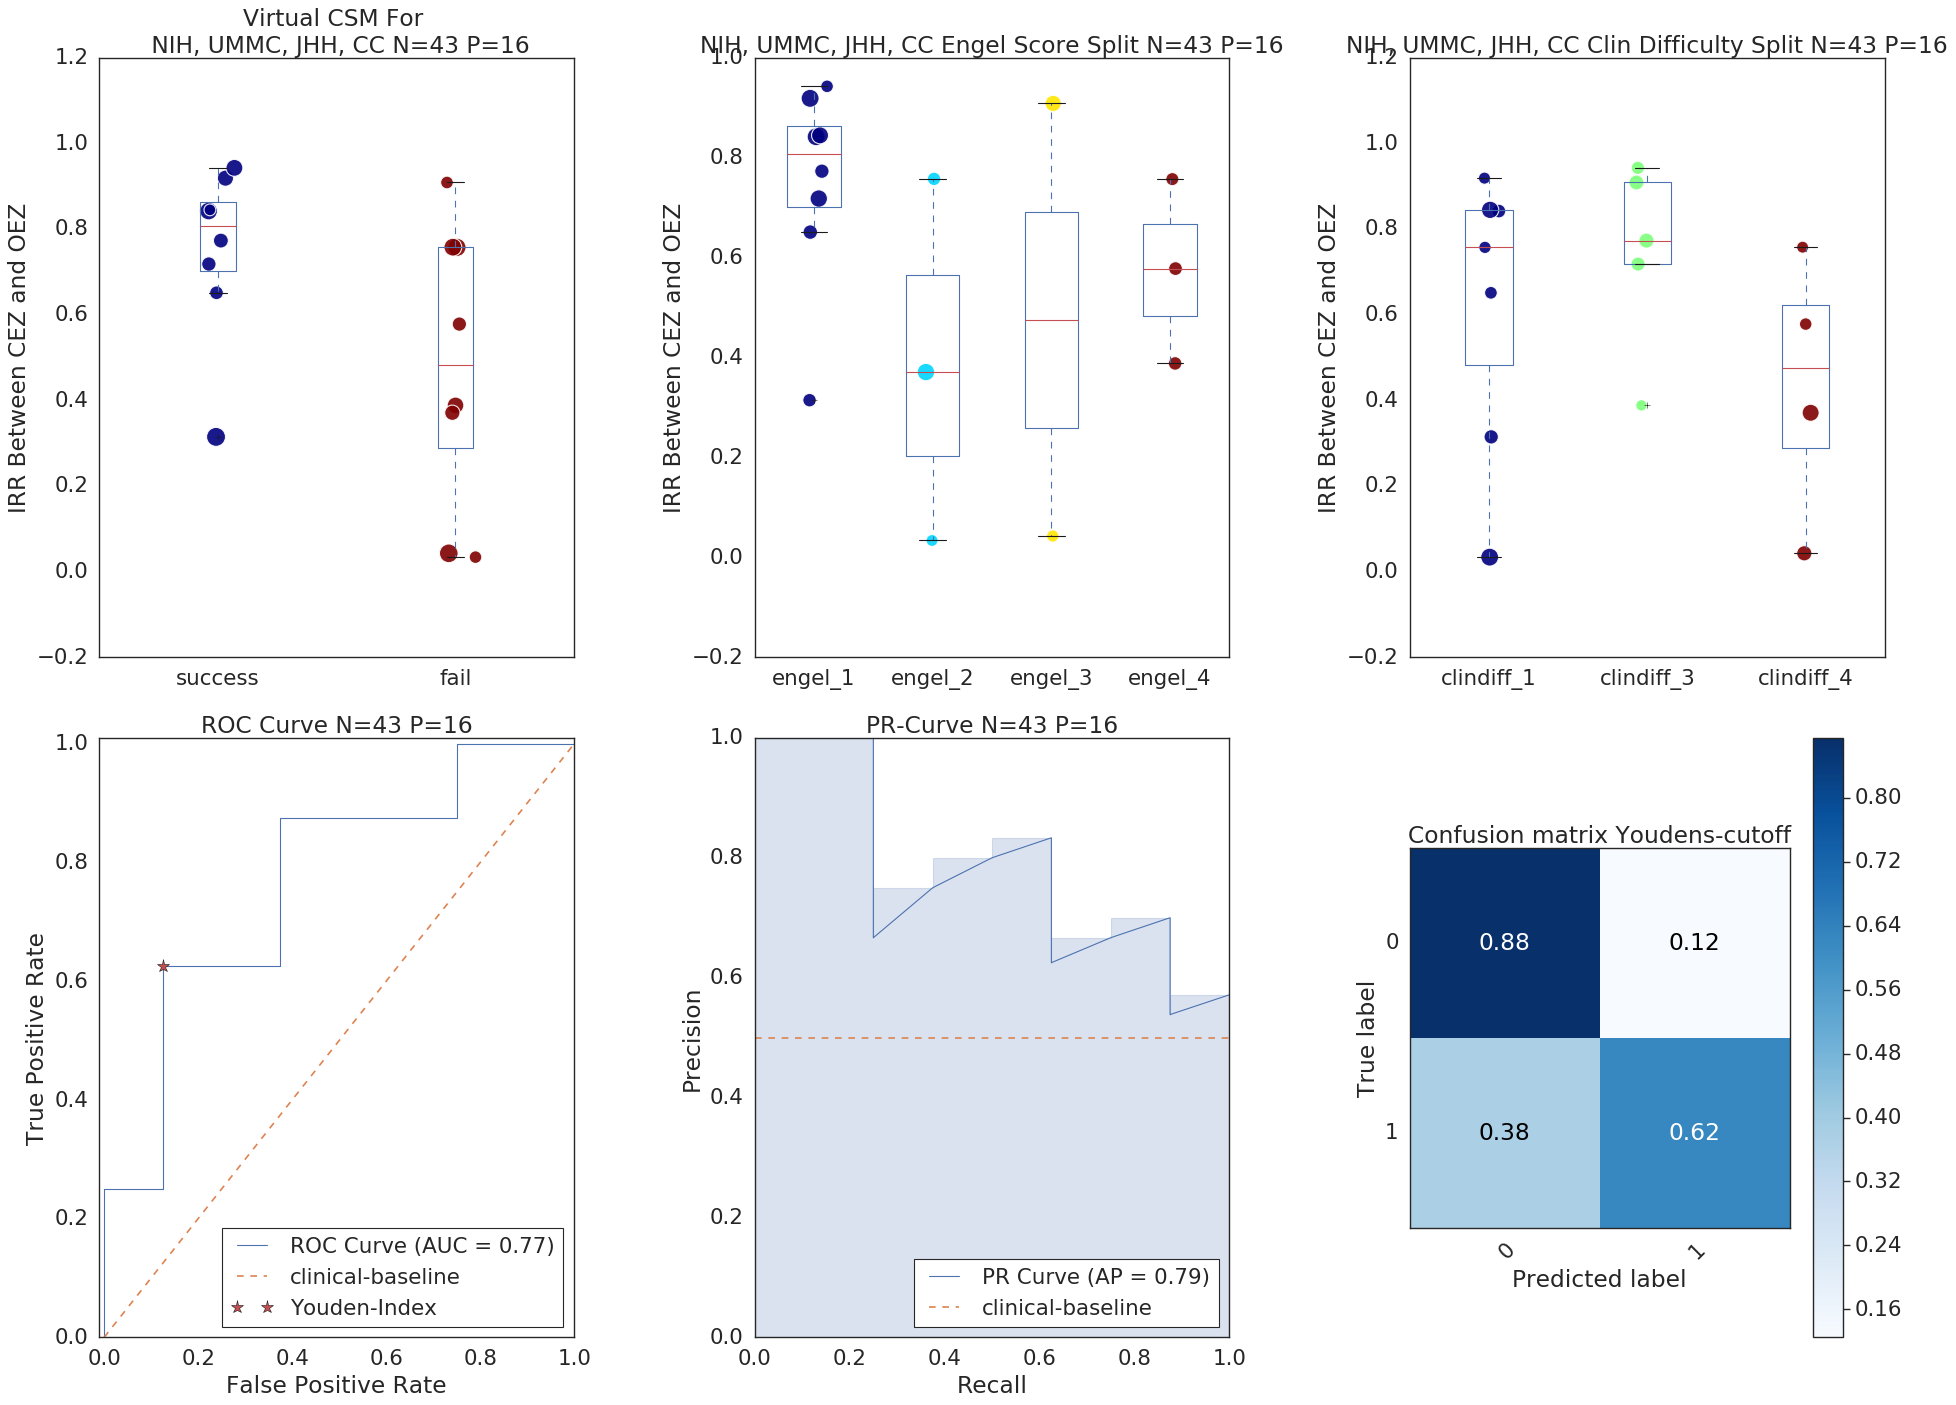

In [224]:
center = "NIH, UMMC, JHH, CC"
numdatasets = totaldatasets
numpats = totalpatients
titlestr = f"Virtual CSM For \n {center} N={numdatasets} P={numpats}"
ylabel = "IRR Between CEZ and OEZ"
clinical_baseline = 0.5
baselinex_roc = [0, 1-(clinical_baseline-0.5)]
baseliney_roc = [0+(clinical_baseline-0.5), 1]
baselinex_pr = [0, 1]
baseliney_pr = [clinical_baseline, clinical_baseline]

# make box plot
plt.style.use("classic")
sns.set(font_scale=1.75)
sns.set_style("white")
fix, axs = plt.subplots(2,3, figsize=(25,18))
axs = axs.flatten()
ax = axs[0]
boxdict = [
    [succ_ezratio, fail_ezratio],
    ['success', 'fail']
    ]
plot_boxplot(ax, boxdict, titlestr, ylabel)

ax = axs[1]
titlestr = f"{center} Engel Score Split N={numdatasets} P={numpats}"
plot_boxplot(ax, engelscore_box, titlestr, ylabel)

ax = axs[2]
titlestr = f"{center} Clin Difficulty Split N={numdatasets} P={numpats}"
plot_boxplot(ax, clindiff_box, titlestr, ylabel)


# make ROC Curve plot
ax = axs[3]
titlestr = f"ROC Curve N={numdatasets} P={numpats}"
label = "ROC Curve (AUC = %0.2f)" % (roc_auc)
plot_roc(ax, fpr, tpr, label, titlestr)
plot_baseline(ax, baselinex_roc, baseliney_roc)
ax.plot(fpr[youden_ind], tpr[youden_ind], 
        'r*', linewidth=4, markersize=12, label=f"Youden-Index")# {np.round(acc, 2)}")
ax.legend(loc='lower right')

# plot operating points
# ax.plot(0, tpr[bestnegind], 
#         'r*', markersize=10, label="Thresh=%0.3f" % (rocthresholds[1]))
# ax.plot(fpr[bestposind], 1, 
#         'g*', markersize=10, label="Thresh=%0.3f" % (rocthresholds[0]))
# ax.plot(fpr[optimal_ind], tpr[optimal_ind], 
#         'k*', markersize=10, label="Thresh=%0.3f" % (rocthresholds[2]))
# make PR Curve
ax = axs[4]
label = 'PR Curve (AP = %0.2f)' % (average_precision)
titlestr = f"PR-Curve N={numdatasets} P={numpats}"
plot_pr(ax, recall, prec, label, titlestr)
plot_baseline(ax, baselinex_pr, baseliney_pr)
ax.legend(loc='lower right')

# make ROC Curve plot
ax = axs[5]
titlestr = f"Confusion matrix Youdens-cutoff"
plot_confusion_matrix(ax, ytrue, ypred, classes=[0.,1.],
                      title=titlestr, normalize=True)
plt.tight_layout()

In [189]:
print("Outlier min on fratio_succ: ", pat_succ[succ_ezratio==min(succ_ezratio)])
print("Outlier max oon fratio_fail: ", pat_fail[fail_ezratio==max(fail_ezratio)])

Outlier min on fratio_succ:  ['pt15']
Outlier max oon fratio_fail:  ['pt6']


In [222]:
print(len(succ_ezratio), len(fail_ezratio))
acc = accuracy_score(y_pred=ypred, y_true=ytrue)
print(acc)

8 8
0.75
